In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cPickle as pickle

plt.rcParams["figure.figsize"] = (20,10)

%matplotlib inline

In [2]:
color_dict = {
    1610612737: ('#E13A3E', 'ATL'),
    1610612738: ('#008348', 'BOS'),
    1610612751: ('#061922', 'BKN'),
    1610612766: ('#1D1160', 'CHA'),
    1610612741: ('#CE1141', 'CHI'),
    1610612739: ('#860038', 'CLE'),
    1610612742: ('#007DC5', 'DAL'),
    1610612743: ('#4D90CD', 'DEN'),
    1610612765: ('#006BB6', 'DET'),
    1610612744: ('#FDB927', 'GSW'),
    1610612745: ('#CE1141', 'HOU'),
    1610612754: ('#00275D', 'IND'),
    1610612746: ('#ED174C', 'LAC'),
    1610612747: ('#552582', 'LAL'),
    1610612763: ('#0F586C', 'MEM'),
    1610612748: ('#98002E', 'MIA'),
    1610612749: ('#00471B', 'MIL'),
    1610612750: ('#005083', 'MIN'),
    1610612740: ('#002B5C', 'NOP'),
    1610612752: ('#006BB6', 'NYK'),
    1610612760: ('#007DC3', 'OKC'),
    1610612753: ('#007DC5', 'ORL'),
    1610612755: ('#006BB6', 'PHI'),
    1610612756: ('#1D1160', 'PHX'),
    1610612757: ('#E03A3E', 'POR'),
    1610612758: ('#724C9F', 'SAC'),
    1610612759: ('#BAC3C9', 'SAS'),
    1610612761: ('#000000', 'TOR'),
    1610612762: ('#00471B', 'UTA'),
    1610612764: ('#002B5C', 'WAS'),
}

In [418]:
# gameid='0021500188'
# gameid = '0021500477'
gameid='0021500219'

# directories
# CHANGE HERE
data_dir = 'raptors/'
game_dir = data_dir+'data/'
court_path = data_dir + 'nba_court_T.png'


#open the pickle file
with open(game_dir+gameid+'.pkl', 'rb') as handle:
    datta = pickle.load(handle)

In [3]:
def draw_court(ii, jj):
    num_events = len(datta['events'])

    player_fields = datta['events'][0]['home']['players'][0].keys()
    # CHANGE THIS
    # specify an event number

    home_players = pd.DataFrame(data=[i for i in datta['events'][0]['home']['players']], columns=player_fields)
    away_players = pd.DataFrame(data=[i for i in datta['events'][0]['visitor']['players']], columns=player_fields)
    players = pd.merge(home_players, away_players, how='outer')
    jerseydict = dict(zip(players.playerid.values, players.jersey.values))

    # get the position of the players and the ball throughout the event
    ball_xy = np.array([x[5][0][2:5] for x in datta['events'][ii]['moments']]) #create matrix of ball data
    player_xy = np.array([np.array(x[5][1:])[:,:4] for x in datta['events'][ii]['moments']]) #create matrix of player data

    # get the play by play data for this clip
    playbyplay = datta['events'][ii]['playbyplay']
    team_1_xy_mean = -np.ones((len(player_xy),2))
    team_2_xy_mean = -np.ones((len(player_xy),2))


    # CHANGE THIS
    # plot a certain frame:
    #jj = (len(player_xy) - 1) / 2

    print('event ' + str(ii) + '/' + str(num_events) + ", moment: "+ str(jj) + '/'+ str(len(player_xy)))
    fig = plt.figure()
    ax = plt.gca() #create axis object


    img = mpimg.imread(court_path)  # read image. I got this image from gmf05's github.

    plt.imshow(img, extent=[0,94,0,50], zorder=0)  # show the image.

    # get player and ball data for the momenet
    ball = ball_xy[jj]
    player = player_xy[jj]

    # plot clock info
    clock_info = ax.annotate('', xy=[94.0/2 - 6.0/1.5 +0.1, 50 - 6.0/1.5 -0.35],
        color='black', horizontalalignment='center', verticalalignment='center')

    if not datta['events'][ii]['moments'][jj][0] == None:
        quarter = datta['events'][ii]['moments'][jj][0]
    else:
        quarter = 0

    if not datta['events'][ii]['moments'][jj][2] == None:
        game_clock = datta['events'][ii]['moments'][jj][2]
    else:
        game_clock = 0

    if not datta['events'][ii]['moments'][jj][3] == None:
        game_shot = datta['events'][ii]['moments'][jj][3]
    else:
        game_shot = 0

    clock_test = 'Quarter {:d}\n {:02d}:{:02d}\n {:03.1f}'.format(
        quarter,
        int(game_clock) % 3600 // 60,
        int(game_clock) % 60,
        game_shot)
    clock_info.set_text(clock_test)

    # the event title
    temp = str(datta['events'][ii]['home']['abbreviation'])+\
        ' vs. ' + str(datta['events'][ii]['visitor']['abbreviation'])+\
        ' (' + str(ii) + ',  ' + str(jj) + ')' +\
        '\n'
    counter = 0 
    for idx, pp in playbyplay.iterrows():
        counter = counter + 1
        if counter > 5:
            break
        temp = temp + str(pp['HOMEDESCRIPTION'])+ " , " +\
                str(pp['VISITORDESCRIPTION'])+ " , "+\
                str(pp['PCTIMESTRING'])+ " , "+\
                str(pp['event_str'])  + '\n'


    plt.title(temp)

    for kk in range(player.shape[0]): #create circle object and text object for each player

        #
        #kk = 1
        #
        team_id = player[kk,0]
        player_id = player[kk,1]
        xx = player[kk,2]
        yy  =player[kk, 3]

        # player circle
        player_circ = plt.Circle((xx,yy), 2.2,
                        facecolor=color_dict[team_id][0],edgecolor='k')
        ax.add_artist(player_circ)

        # player jersey # (text)
        ax.text(xx,yy,jerseydict[player_id],color='w',ha='center',va='center')

    # draw the ball
    ball_circ = plt.Circle((ball[0], ball[1]), ball[2]/3, color=[1, 0.4, 0])  # create circle object for bal
    ax.add_artist(ball_circ)

    # add the average position of each team tp the frame
    team_ids = np.unique(player[:,0])

    team_1_xy = player[player[:,0] == team_ids[0]]
    team_1_xy = team_1_xy[:,[2,3]]
    team_1_xy_mean[jj,:] = np.mean(team_1_xy,0)
    plt.plot(team_1_xy_mean[:jj+1,0],team_1_xy_mean[:jj+1,1],'o',
             color=color_dict[team_ids[0]][0],
             alpha=0.2)


    team_2_xy = player[player[:,0] == team_ids[1]]
    team_2_xy = team_2_xy[:,[2,3]]
    team_2_xy_mean[jj,:] = np.mean(team_2_xy,0)
    plt.plot(team_2_xy_mean[:jj+1,0],team_2_xy_mean[:jj+1,1],'o',
             color=color_dict[team_ids[1]][0],
             alpha=0.2)

    plt.xlim([0,94])
    plt.ylim([0,50])

    plt.tight_layout(pad=0, w_pad=0.5, h_pad=0)


In [4]:
def time_conversion(quarter, time_left_in_quarter):
    time_passed = quarter * 12 * 60 - time_left_in_quarter
    time_left_in_game = (48 * 60) - time_passed
    return time_left_in_game

In [5]:
# Find the scoring with assis moments
def get_events(ddata):
    ast_list = []
    attacker = []
    shooter = []
    assist = []
    ast_events = []
    home_team = datta['events'][0]['home']['teamid']
    away_team = datta['events'][0]['visitor']['teamid']
    num_events = len(datta['events'])
    
    # Look through the data locate where the scoring with assist happens
    for i in xrange(num_events):
        playbyplay = datta['events'][i]['playbyplay']
        for idx, play in playbyplay.iterrows():
            if play['HOMEDESCRIPTION'] != None:
                if play['HOMEDESCRIPTION'].find(' AST)') != -1:
                    # print play['HOMEDESCRIPTION']
                    quarter = play['PERIOD']
                    time_left_in_quarter = play['time_left']
                    time_left_in_game = time_conversion(quarter, time_left_in_quarter)
                    player1 = play['PLAYER1_ID']
                    player2 = play['PLAYER2_ID']
                    # print time_left_in_quarter, time_left_in_game
                    ast_list.append(time_left_in_game)
                    attacker.append(home_team)
                    shooter.append(player1)
                    assist.append(player2)
                    ast_events.append(i)
            if play['VISITORDESCRIPTION'] != None:
                if play['VISITORDESCRIPTION'].find(' AST)') != -1:
                    # print play['VISITORDESCRIPTION']
                    quarter = play['PERIOD']
                    time_left_in_quarter = play['time_left']                
                    time_left_in_game = time_conversion(quarter, time_left_in_quarter)
                    player1 = play['PLAYER1_ID']
                    player2 = play['PLAYER2_ID']
                    # print time_left_in_quarter, time_left_in_game
                    ast_list.append(time_left_in_game)
                    attacker.append(away_team)
                    shooter.append(player1)
                    assist.append(player2)
                    ast_events.append(i)

    ast_events = list(set(ast_events))
    ast_events.sort()
    ast_times, index = np.unique(ast_list, return_index = True)
    attacker = np.array([attacker[i] for i in index])
    shooter = np.array([shooter[i] for i in index])
    assist = np.array([assist[i] for i in index])
    event_data = pd.DataFrame(data={'attack': attacker, 'time':ast_times, 'shooter': shooter, 'assist':assist})
    
    return event_data

In [12]:
# Get the start time of each event
def combine_moments(datta):
    home_team = datta['events'][0]['home']['teamid']
    away_team = datta['events'][0]['visitor']['teamid']

    num_events = len(datta['events'])
    event_start_time = []
    for i in xrange(num_events):
        moment = datta['events'][i]['moments']
        quarter = moment[0][0]
        time_left_in_quarter = moment[0][2]
        event_start_time.append(time_conversion(quarter, time_left_in_quarter))
    
    # Get the list of frames of events where AST happens wihtout overlap
    moment_data = []
    moment_location = []
    for i in reversed(xrange(num_events)):
        print i, num_events
        moment = datta['events'][i]['moments']
        pbp = datta['events'][i]['playbyplay'].empty
        for j in reversed(xrange(len(moment))):
            quarter = moment[j][0]
            time_left_in_quarter = moment[j][2]
            time_left_in_game = time_conversion(quarter, time_left_in_quarter)

            if time_left_in_game == event_start_time[i]:
                break

            # Get meta data
            a = moment[j][:4]
            a.append(i)
            a.append(j)
            a.append(pbp)

            moment_data.append(a)        
            # Get location data
            location = pd.DataFrame(moment[j][5])
            ball = location.iloc[0, :]
            home = location[location[0] == home_team]
            away = location[location[0] == away_team]
            moment_location.append([ball, home, away])
    return moment_data, moment_location

In [7]:
# Go through and find frames exactly where shot happens and when assist happens
# Check when the clock resets

def get_shot(moment_data, moment_location, event_data, slack_time=5):
    search_counter = 0
    prev_shot_clock = 24
    moment_list = []
    event_list = []
    for i in xrange(len(moment_data)):
        quarter = moment_data[i][0]
        time_left_in_quarter = moment_data[i][2]
        shot_clock = moment_data[i][3]
        time_left_in_game = time_conversion(quarter, time_left_in_quarter)
        search_time = event_data.time[search_counter]

        if prev_shot_clock > shot_clock and shot_clock != None \
                                        and prev_shot_clock != None \
                                        and prev_time_left_in_game > event_data.time[search_counter]:
            # print prev_shot_clock, shot_clock, time_left_in_game
            # print "Shot Clock Reset", time_left_in_game, prev_shot_clock, shot_clock
            if time_left_in_game > search_time - slack_time:
                if (prev_shot_clock - shot_clock) > 0.5 and prev_shot_clock > 23.9 \
                                                        and moment_data[i][-1] == False \
                                                        and (time_left_in_game - event_data.time[search_counter]) < 5:
                    print 'shot', moment_data[i], prev_time_left_in_game, event_data.time[search_counter], prev_shot_clock, shot_clock, search_counter
                    moment_list.append(i)
                    event_list.append(search_counter)
                search_counter = search_counter + 1

        prev_shot_clock = shot_clock
        prev_time_left_in_game = time_left_in_game

        if search_counter >= len(event_data):
            break
    return event_list, moment_list

In [14]:
def find_shot_and_assist(datta, moment_location, moment_list, event_data, event_list, fps = 25, search_sec = 10):
    shot_frames = []
    assist_frames = []
    home_team = datta['events'][0]['home']['teamid']
    away_team = datta['events'][0]['visitor']['teamid']


    for i in xrange(len(moment_list)):
        shooter_found = False
        len_ed = len(event_data) - 1
        index = moment_list[i]
        event_d = event_data.iloc[event_list[i]]
        shooter_id = event_d.shooter
        assister_id = event_d.assist
        event_time = event_d.time

        print shooter_id, assister_id

        quarter = moment_data[index][0]    
        time_left_in_quarter = moment_data[index][2]
        shot_clock = moment_data[index][3]
        time_left_in_game = time_conversion(quarter, time_left_in_quarter)    
        attacker = event_d.attack
        # print event_time, time_left_in_game
        print moment_data[index]

        for track_back_frame in xrange(1, fps * search_sec):
            location = moment_location[index + track_back_frame]
            ball_location = location[0]
            home_location = location[1]
            away_location = location[2]
            # print index
            # print moment_location[index + 1]
            # print moment_data[index + track_back_frame]
            # print attacker == home_team

            if attacker == home_team:
                shooter_location = home_location[home_location.loc[:,1] == shooter_id]
                assister_location = home_location[home_location.loc[:,1] == assister_id]
            else:
                shooter_location = away_location[away_location.loc[:,1] == shooter_id]
                assister_location = away_location[away_location.loc[:,1] == assister_id]
            ball_xy = ball_location.iloc[2:4].as_matrix()
            ball_height = ball_location[4]

            if shooter_location.empty or assister_location.empty:
                continue

            if shooter_found == True:
                assist_xy = assister_location.iloc[:,2:4].as_matrix().flatten()
                distance = np.linalg.norm(assist_xy - ball_xy)

                if distance <= 2.0:
                    print 'Assist Found'
                    print moment_data[index + track_back_frame]
                    assist_frames.append(index + track_back_frame)
                    break

            if shooter_found == False:
                shooter_xy = shooter_location.iloc[:,2:4].as_matrix().flatten()
                distance = np.linalg.norm(shooter_xy - ball_xy)    

                if distance <= 5.0 and ball_height <= 8:
                    print 'Shooting Found'
                    print moment_data[index + track_back_frame]
                    shot_frames.append(index + track_back_frame)

                    shooter_found = True
    return shot_frames, assist_frames

In [16]:
# gameid='0021500188'
# gameid = '0021500477'
gameid='0021500219'

# directories
# CHANGE HERE
data_dir = 'raptors/'
game_dir = data_dir+'data/'
court_path = data_dir + 'nba_court_T.png'


#open the pickle file
with open(game_dir+gameid+'.pkl', 'rb') as handle:
    datta = pickle.load(handle)

    home_team = datta['events'][0]['home']['teamid']
    away_team = datta['events'][0]['visitor']['teamid']

    event_data = get_events(datta)
    moment_data, moment_location = combine_moments(datta)
    event_list, moment_list = get_shot(moment_data, moment_location, event_data)
    shot_frames, assist_frames = find_shot_and_assist(datta, moment_location, moment_list, event_data, event_list)
    print len(shot_frames)

224 225
223 225
222 225
221 225
220 225
219 225
218 225
217 225
216 225
215 225
214 225
213 225
212 225
211 225
210 225
209 225
208 225
207 225
206 225
205 225
204 225
203 225
202 225
201 225
200 225
199 225
198 225
197 225
196 225
195 225
194 225
193 225
192 225
191 225
190 225
189 225
188 225
187 225
186 225
185 225
184 225
183 225
182 225
181 225
180 225
179 225
178 225
177 225
176 225
175 225
174 225
173 225
172 225
171 225
170 225
169 225
168 225
167 225
166 225
165 225
164 225
163 225
162 225
161 225
160 225
159 225
158 225
157 225
156 225
155 225
154 225
153 225
152 225
151 225
150 225
149 225
148 225
147 225
146 225
145 225
144 225
143 225
142 225
141 225
140 225
139 225
138 225
137 225
136 225
135 225
134 225
133 225
132 225
131 225
130 225
129 225
128 225
127 225
126 225
125 225
124 225
123 225
122 225
121 225
120 225
119 225
118 225
117 225
116 225
115 225
114 225
113 225
112 225
111 225
110 225
109 225
108 225
107 225
106 225
105 225
104 225
103 225
102 225
101 225
100 225


Shooting Found
[1, 1448498846408, 395.97, 8.42, 20, 310, False]
Assist Found
[1, 1448498845049, 397.33, 9.67, 20, 276, False]
2544 201567
[1, 1448498826649, 415.77, 20.41, 19, 66, False]
Shooting Found
[1, 1448498826609, 415.81, 20.44, 19, 65, False]
201567 2544
[1, 1448498728052, 495.44, 13.34, 14, 126, False]
Shooting Found
[1, 1448498727132, 496.36, 14.2, 14, 103, False]
Assist Found
[1, 1448498724732, 498.76, 16.45, 14, 43, False]
203099 2747
[1, 1448498607776, 587.91, 8.01, 7, 294, False]
Shooting Found
[1, 1448498606176, 589.51, 9.38, 7, 254, False]
Assist Found
[1, 1448498605016, 590.67, 10.37, 7, 225, False]
202684 2544
[1, 1448498510259, 685.42, 9.12, 1, 256, False]
Shooting Found
[1, 1448498509179, 686.5, 10.17, 1, 229, False]
Assist Found
[1, 1448498506899, 688.78, 12.39, 1, 172, False]
28


1149
event 223/225, moment: 499/875
1949
event 222/225, moment: 391/693
4213
event 218/225, moment: 145/474
16254
event 187/225, moment: 127/475
25073
event 168/225, moment: 742/1026
40172
event 141/225, moment: 414/750
43524
event 134/225, moment: 158/475
44521
event 131/225, moment: 107/500
45754
event 129/225, moment: 497/825
47311
event 128/225, moment: 414/1475
48980
event 127/225, moment: 294/1550
49602
event 126/225, moment: 446/775
57011
event 106/225, moment: 72/173
61595
event 94/225, moment: 586/1176
62536
event 93/225, moment: 219/575
64693
event 88/225, moment: 67/280
66642
event 83/225, moment: 402/750
68028
event 81/225, moment: 121/450
72023
event 74/225, moment: 320/700
77582
event 61/225, moment: 174/525
81021
event 52/225, moment: 281/650
83444
event 47/225, moment: 115/823
89071
event 35/225, moment: 76/312
97540
event 20/225, moment: 348/549
98620
event 19/225, moment: 66/799
101603
event 14/225, moment: 126/525
105325
event 7/225, moment: 294/625
109182
event 1/22

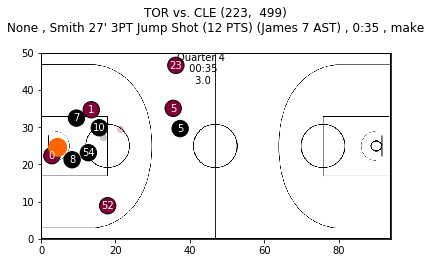

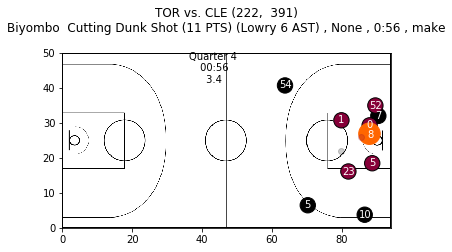

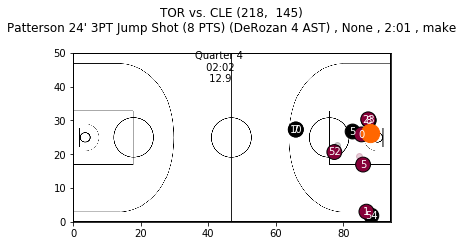

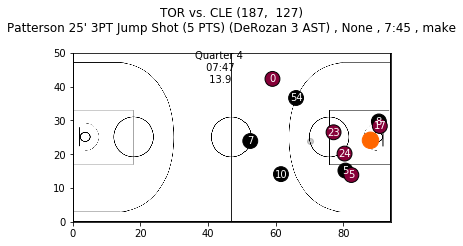

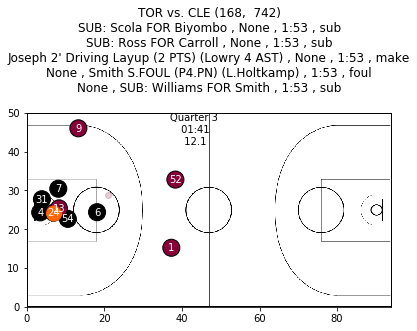

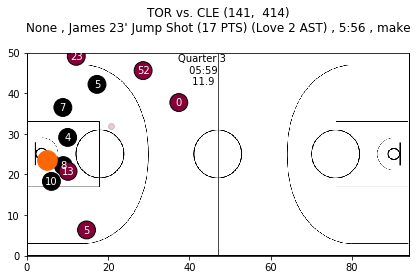

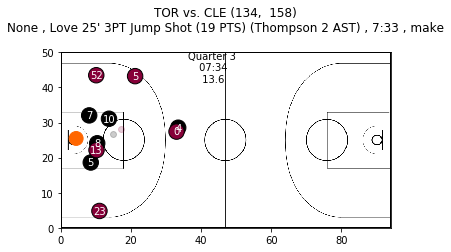

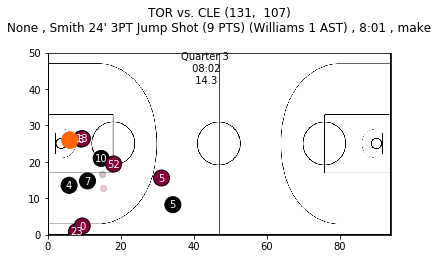

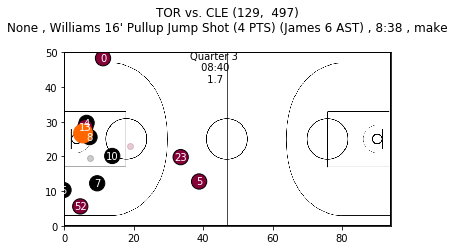

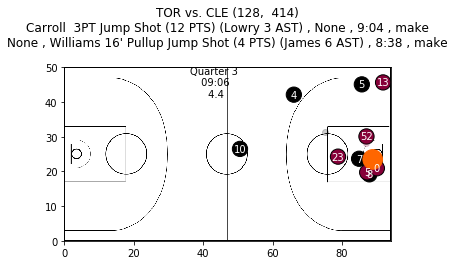

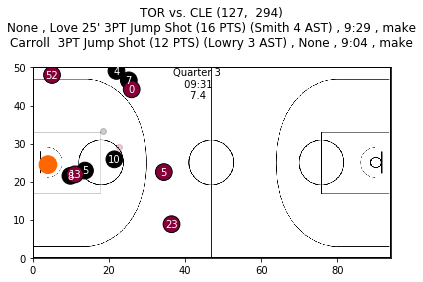

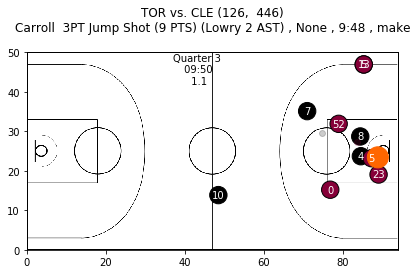

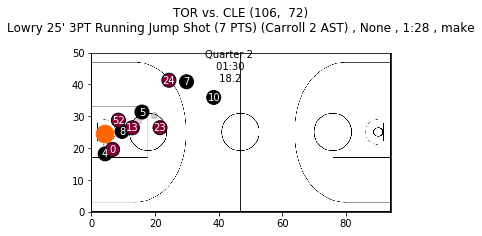

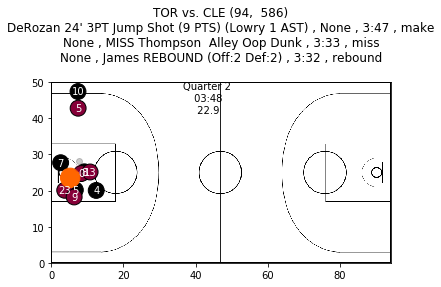

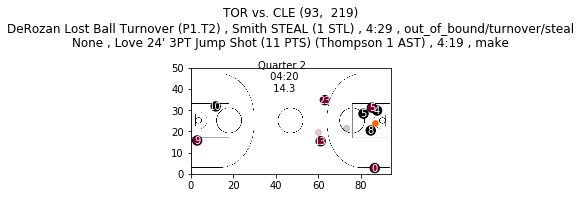

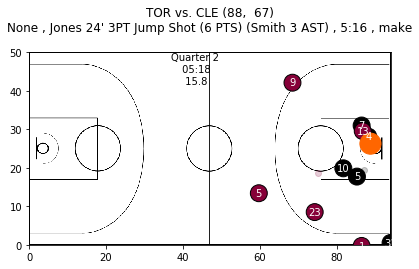

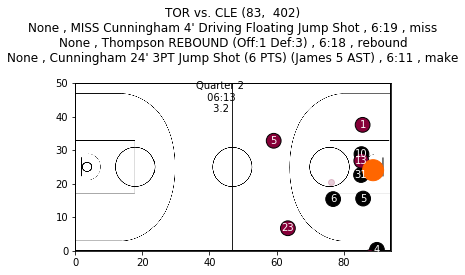

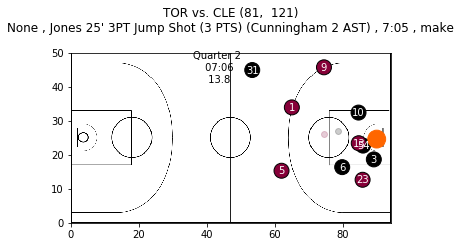

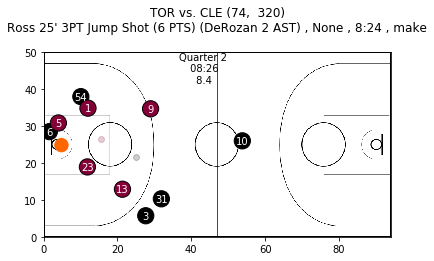

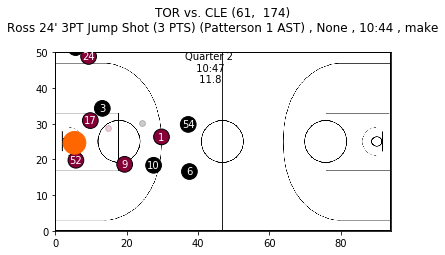

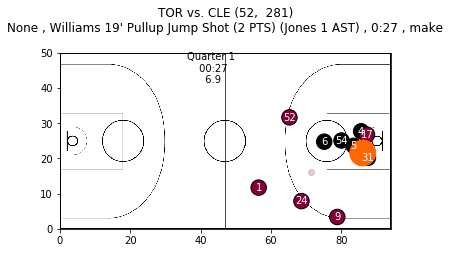

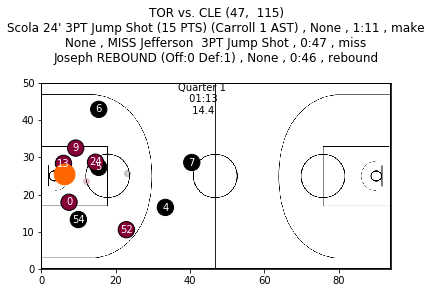

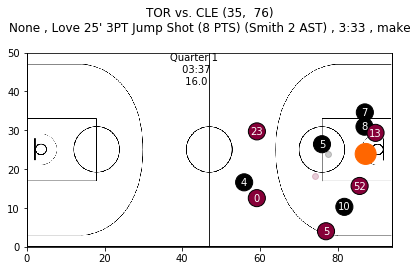

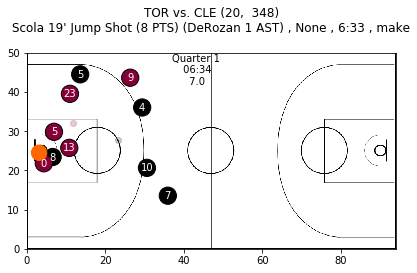

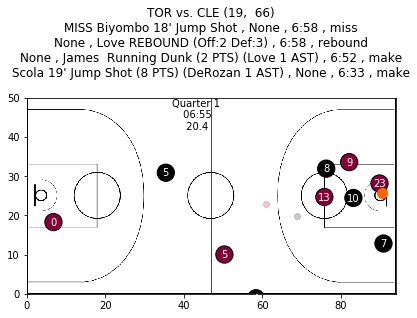

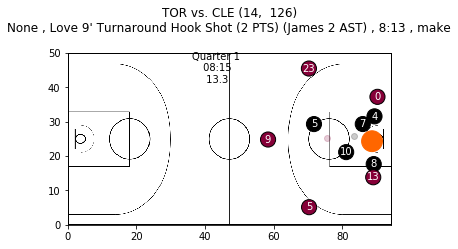

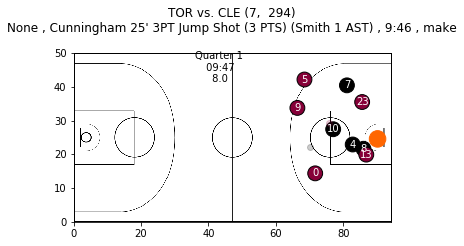

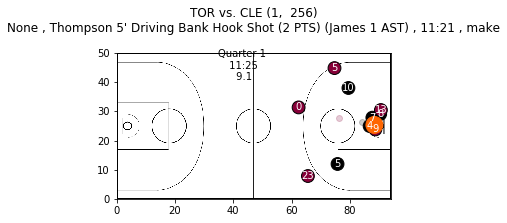

In [17]:
# for i in assist_frames:
# for i in shot_frames:
for i in moment_list:
    print i
    md = moment_data[i]
    draw_court(md[4], md[5])

event 138/217, moment: 1696/11370
event 138/217, moment: 1697/11370
event 138/217, moment: 1698/11370
event 138/217, moment: 1699/11370
event 138/217, moment: 1700/11370
event 138/217, moment: 1701/11370
event 138/217, moment: 1702/11370
event 138/217, moment: 1703/11370
event 138/217, moment: 1704/11370
event 138/217, moment: 1705/11370
event 138/217, moment: 1706/11370
event 138/217, moment: 1707/11370
event 138/217, moment: 1708/11370
event 138/217, moment: 1709/11370
event 138/217, moment: 1710/11370
event 138/217, moment: 1711/11370
event 138/217, moment: 1712/11370
event 138/217, moment: 1713/11370
event 138/217, moment: 1714/11370
event 138/217, moment: 1715/11370


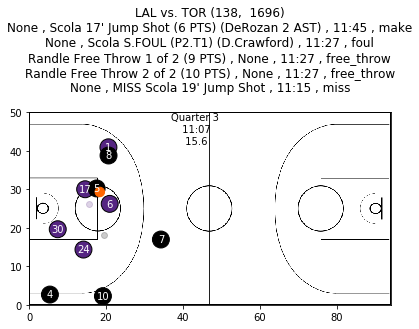

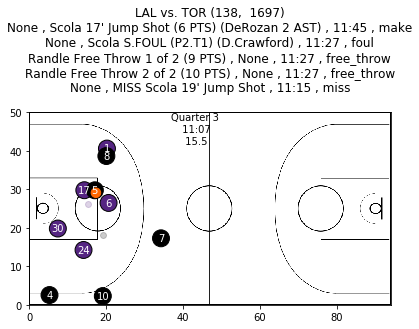

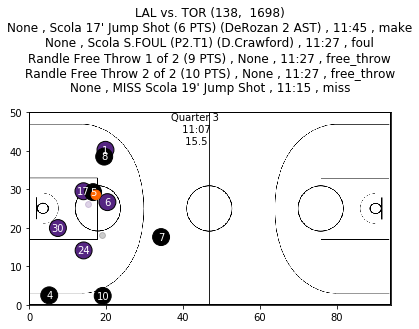

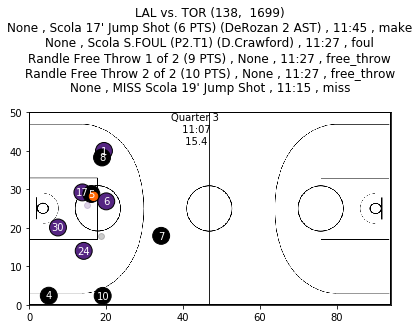

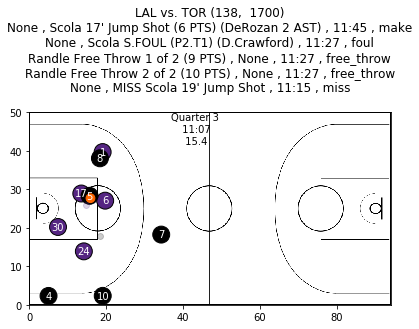

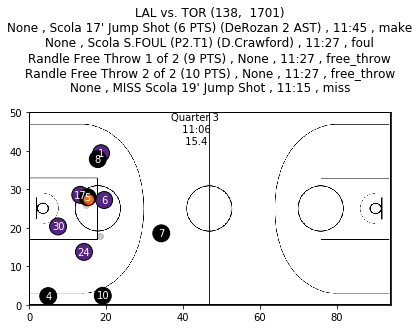

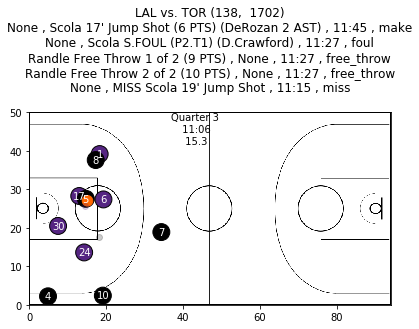

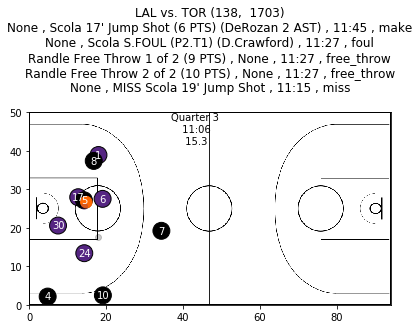

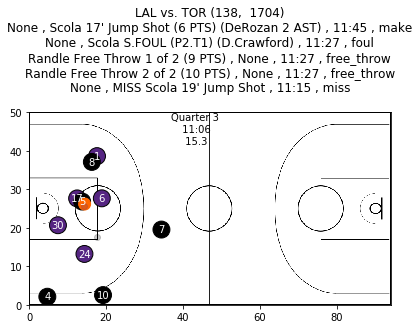

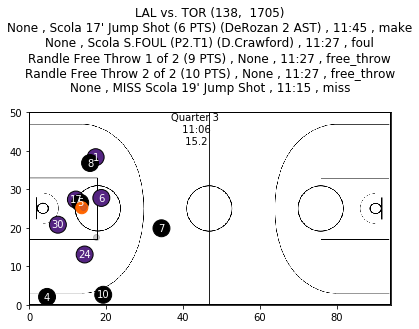

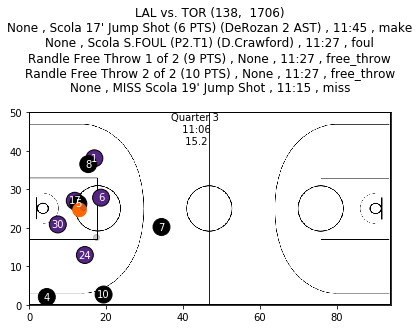

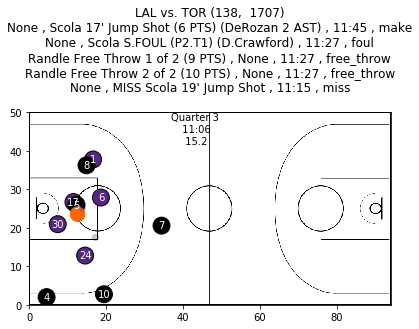

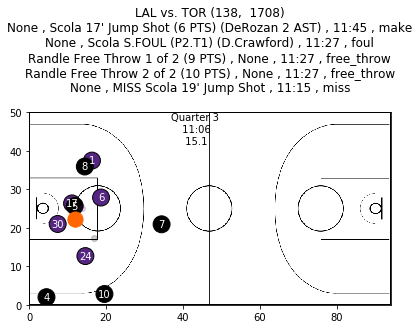

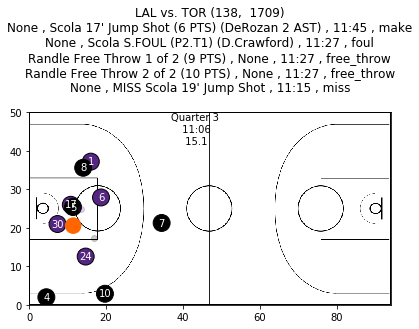

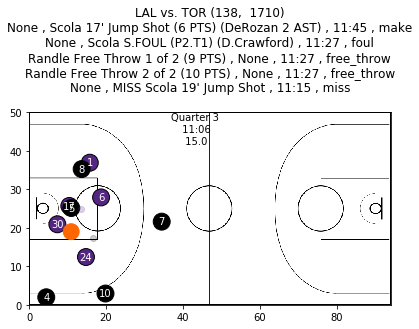

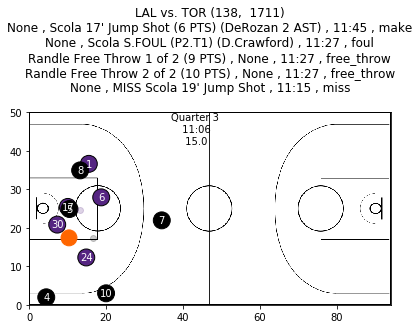

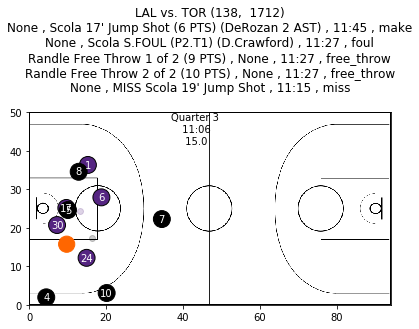

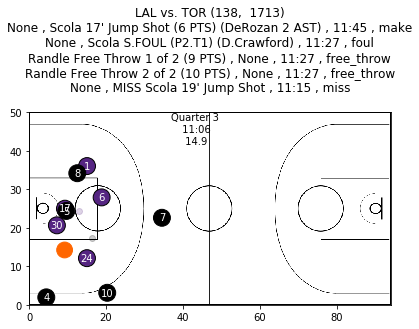

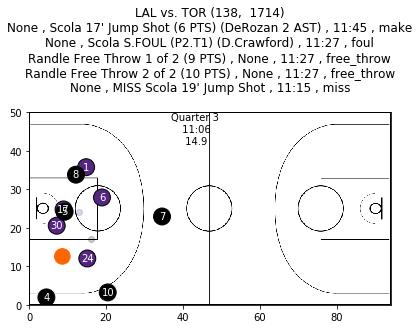

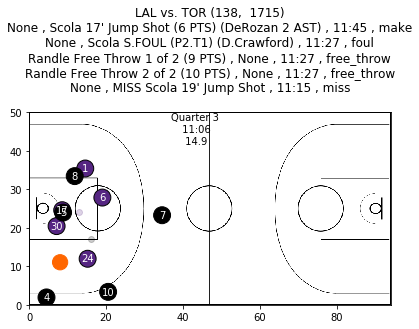

In [412]:
event = 138
moment_count = 1706
difference = 10
for i in xrange((moment_count-difference),(moment_count+difference)):
    draw_court(event, i)


In [291]:

print home_team, away_team
prev = pd.DataFrame(moment_list[0][5])

compiled = [ball, home, away]
for moment in moment_list:
    curr = np.array(moment[5])
    if curr != prev:
        print 'changed'
        break
    prev = curr
    
    
    
    if prev_time_left_in_game == time_left_in_game and time_stopped == False:
        time_stopped = True
        # print 'time stopped'
        # print prev_time_left_in_game, time_left_in_game
    
    if prev_time_left_in_game != time_left_in_game and time_stopped == True:
        time_stopped = False
        # print prev_time_left_in_game, time_left_in_game, search_time
        if prev_time_left_in_game > search_time - slack_time: #and prev_time_left_in_game < search_time + 1:
            print 'time started'
            print 'time', moment_data[i], time_left_in_game, event_data.time[search_counter]            
            search_counter = search_counter + 1
            time_stopped = False

        attack  time
0   1610612761    24
1   1610612747   229
2   1610612747   377
3   1610612761   478
4   1610612761   651
5   1610612747   670
6   1610612761   682
7   1610612747   703
8   1610612761   763
9   1610612761   792
10  1610612761   828
11  1610612747  1029
12  1610612747  1242
13  1610612747  1318
14  1610612761  1382
15  1610612761  1425
16  1610612761  1582
17  1610612747  1612
18  1610612761  1685
19  1610612761  1763
20  1610612747  1790
21  1610612761  1810
22  1610612747  1878
23  1610612761  1968
24  1610612761  2001
25  1610612747  2068
26  1610612747  2110
27  1610612747  2131
28  1610612747  2201
29  1610612761  2222
30  1610612747  2251
31  1610612761  2269
32  1610612761  2332
33  1610612761  2436
34  1610612747  2542
35  1610612747  2566
36  1610612761  2581
37  1610612747  2600
38  1610612747  2634
39  1610612747  2658
40  1610612761  2792


In [147]:
2805.37 / 60

46.756166666666665